# Triple Screen Trading System Strategy

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='')

### TSTS process
* Screen1) By chasing LongEMA, make a decision whether start trading or not.
* Screen2) By taking Stochastic Oscillator, catch a position as reversals.
* Screen3) By considering above two screens, make an order at a slightly upper/lower price.

In [2]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [3]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

In [4]:
def SMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].rolling(window=ndays, min_periods=min_days).mean()

In [5]:
def EMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].ewm(ndays,min_periods=min_days).mean()

In [14]:
def TSTS(pr_df, long_d=130, short_d=60, signal_d=45, n=14, m=3, min_days=1):
    pr = pr_df.copy()
    shortEMA = EMA(pr[['close']], short_d, min_days=min_days)
    longEMA = EMA(pr[['close']], long_d, min_days=min_days)
    pr['MACD'] = shortEMA - longEMA
    pr['Signal'] = EMA(pr[['MACD']], signal_d, min_days=min_days)
    pr['LongEMA'] = longEMA
    pr['ShortEMA'] = shortEMA
    pr['MACD_HIST'] = pr['MACD'] - pr['Signal']
    
    ndays_high = pr['high'].rolling(window=n, min_periods=1).max()
    ndays_low = pr['low'].rolling(window=n, min_periods=1).min()
    fast_k = ((pr['close'] - ndays_low) / (ndays_high - ndays_low)) * 100
    slow_d = fast_k.rolling(m, min_periods=1).mean()
    pr['fast_k'] = fast_k
    pr['slow_d'] = slow_d
    
    return pr

In [37]:
def TSTS_Signal(dff, buy=20, sell=80):
    df = dff.copy()
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['LongEMA'][i-1] < df['LongEMA'][i] and df['slow_d'][i-1]>=buy and df['slow_d'][i]<buy and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['LongEMA'][i-1] > df['LongEMA'][i] and df['slow_d'][i-1]<=sell and df['slow_d'][i]>sell and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    """
    For the first position being long, if SellSignal is prior to BuySignal
    remove that position..
    """
    firstSell = df[df['SellSignal'].notnull()].index[0]
    firstBuy = df[df['BuySignal'].notnull()].index[0]
    if firstBuy > firstSell : 
        df.loc[firstSell,'SellSignal'] = np.nan
    return df

In [36]:
def BackTest(obv):
    tmp = obv[(~obv['BuySignal'].isnull())|(~obv['SellSignal'].isnull())]
    tmp['BuySignal'] = tmp['BuySignal'].fillna(0)
    tmp['SellSignal'] = tmp['SellSignal'].fillna(0)
    tmp['series'] = tmp['BuySignal'] + tmp['SellSignal']
    tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignal!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [68]:
def TSTS_Run(start, end, code, long_d=130, short_d=60, signal_d=45, n=14, m=3, min_p=1, buy=20, sell=80, doplot=True):
    pr = ldr.GetPricelv1(start, end, [code])
    pr = pr.rename(columns={'adjprice':'close'})
    pr.index = pr['DATE'].to_list()
    #pr = pr.reset_index(drop=True)
    pr = pr.drop(['DATE','OPEN','CODE'],axis=1)
    tsts = TSTS(pr, long_d=long_d, short_d=short_d, signal_d=signal_d, n=n, m=m, min_days=min_p)
    tsts_sig = TSTS_Signal(tsts, buy=buy, sell=sell)
    if doplot :
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(14,14))
        p1 = plt.subplot(3,1,1)
        plt.title('Triple Screen Trading System : {}'.format(code))
        plt.grid(True)
        plt.plot(tsts_sig.reset_index().index, tsts_sig['LongEMA'], color='c', label='LongEMA')
        plt.plot(tsts_sig.reset_index().index, tsts_sig['close'], color='black', label='Close', alpha=0.35)
        plt.plot(tsts_sig.reset_index().index, tsts_sig['ShortEMA'], color='navy', label='ShortEMA')
        plt.scatter(tsts_sig.reset_index().index, tsts_sig['BuySignal'], color='green', label='BuySignal', marker='^', alpha=1,linewidths=5)
        plt.scatter(tsts_sig.reset_index().index, tsts_sig['SellSignal'], color='red', label='SellSignal', marker='v', alpha=1,linewidths=5)
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        
        p2 = plt.subplot(3,1,2)
        plt.grid(True)
        plt.bar(tsts_sig.reset_index().index, tsts_sig['MACD_HIST'], color='m', label='MACD-HIST')
        plt.plot(tsts_sig.reset_index().index, tsts_sig['MACD'], color='b', label='MACD')
        plt.plot(tsts_sig.reset_index().index, tsts_sig['Signal'], color='g', label='MACD-Signal')
        plt.legend(loc='upper left')
        
        p3 = plt.subplot(3,1,3)
        plt.grid(True)
        plt.plot(tsts_sig.reset_index().index, tsts_sig['fast_k'], color='c', label='Fast%K')
        plt.plot(tsts_sig.reset_index().index, tsts_sig['slow_d'], color='k', label='Slow%D')
        plt.legend(loc='upper left')
        plt.show()
        
    _, rst = BackTest(tsts_sig)
    rst.index = [code]
    return rst

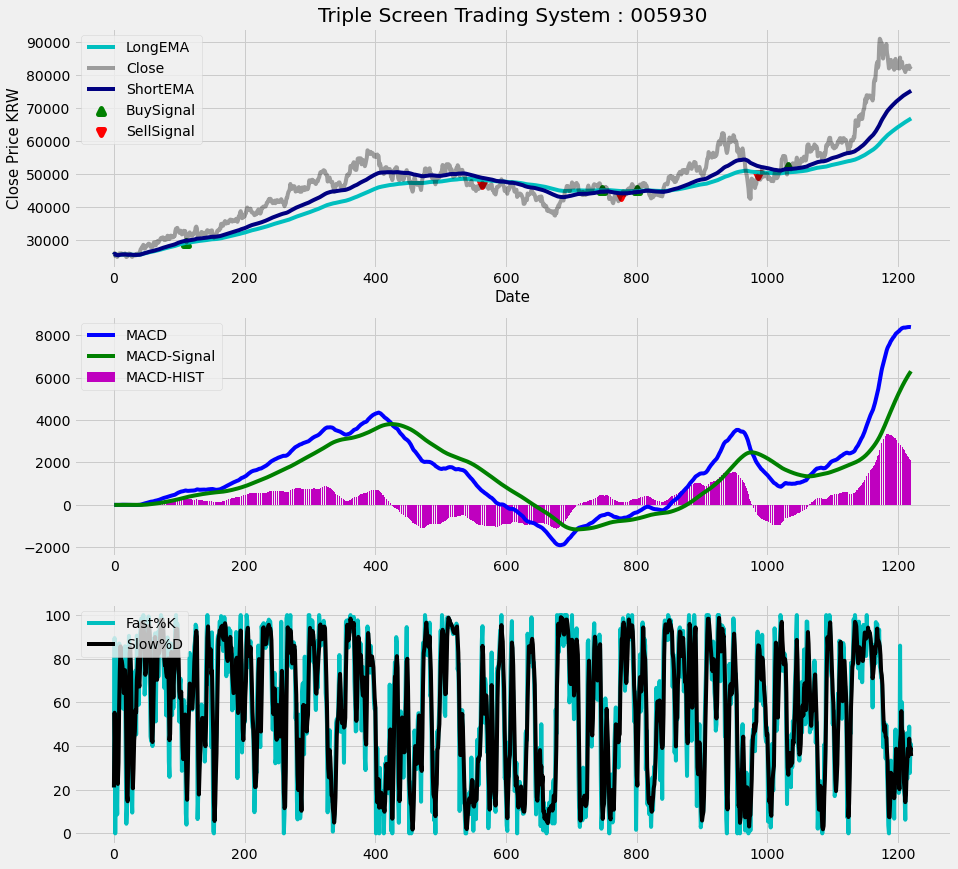

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.69,0.67,0.6,-0.04,0.32,1.22,1.19,3,1.02


In [90]:
TSTS_Run(start, end, '005930',130,60,45,14,3,1,30,70,True)

In [91]:
%%time
total = pd.DataFrame()
start = '2016-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total = pd.concat([total,TSTS_Run(start, end, cd,130,60,45,14,3,1,30,70,False)])

Wall time: 17.4 s


In [92]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.69,0.67,0.6,-0.04,0.32,1.22,1.19,3,1.02
005935,1.68,1,0.68,0.68,0.33,1.68,1.68,1,NaN
034220,1.02,1,0.02,0.02,0.77,1.02,1.02,1,NaN
066570,0.96,0.5,0.2,-0.2,0.63,1,0.98,2,-0.10


# Conclusion
* I think it doesn't give me good signals both in steady and volatile markets.
* As Screen1) and 2) are opposite indicators it seems like collision occur.
* Not recommended...

---